Dataset Shape: (20640, 9)

Missing Values:
 MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
PRICE         0
dtype: int64

Statistical Summary:
              MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude         PRICE  


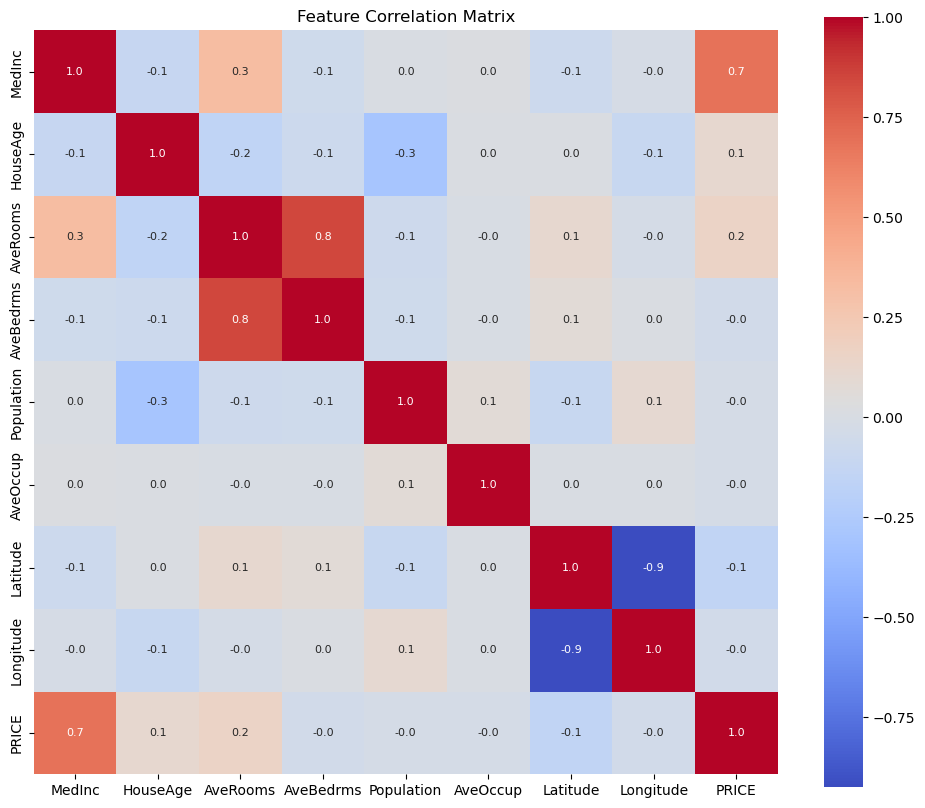


Cross-Validated RMSE: 0.63 ± 0.03

Training Metrics:
R²: 0.8983
MAE: 0.2565
MSE: 0.1360
RMSE: 0.3687
MAPE: 14.41%
Explained Variance: 0.8983

Test Metrics:
R²: 0.8284
MAE: 0.3124
MSE: 0.2249
RMSE: 0.4742
MAPE: 18.20%
Explained Variance: 0.8284


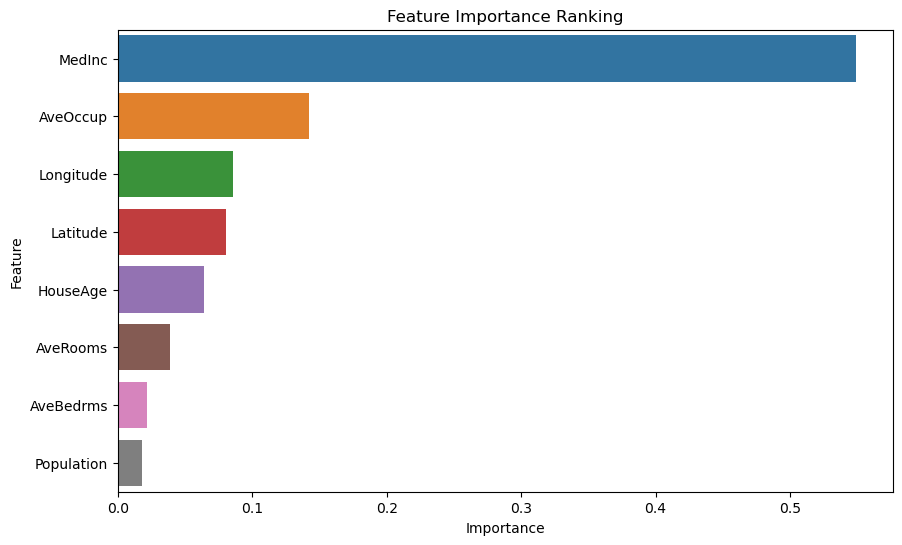

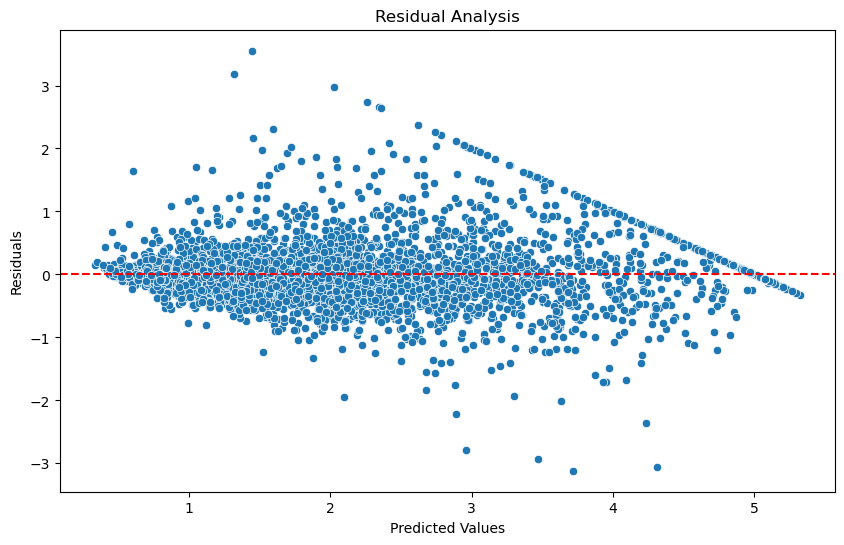

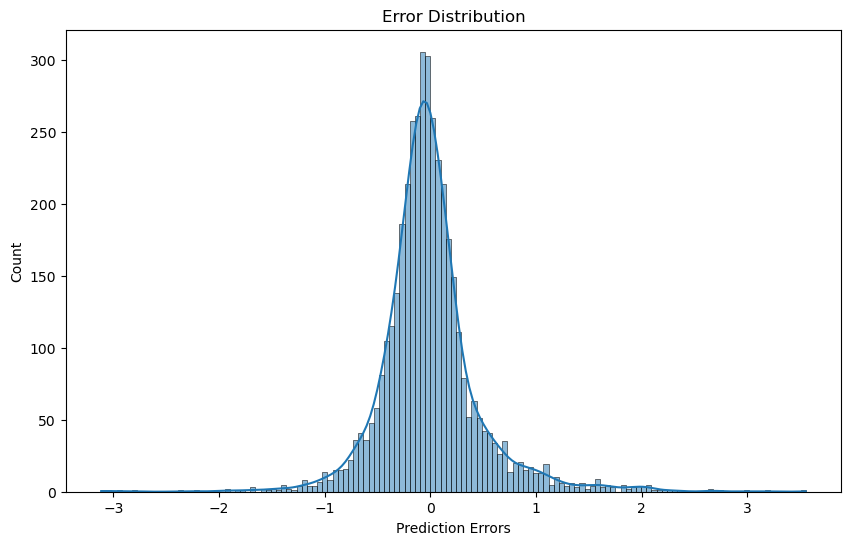

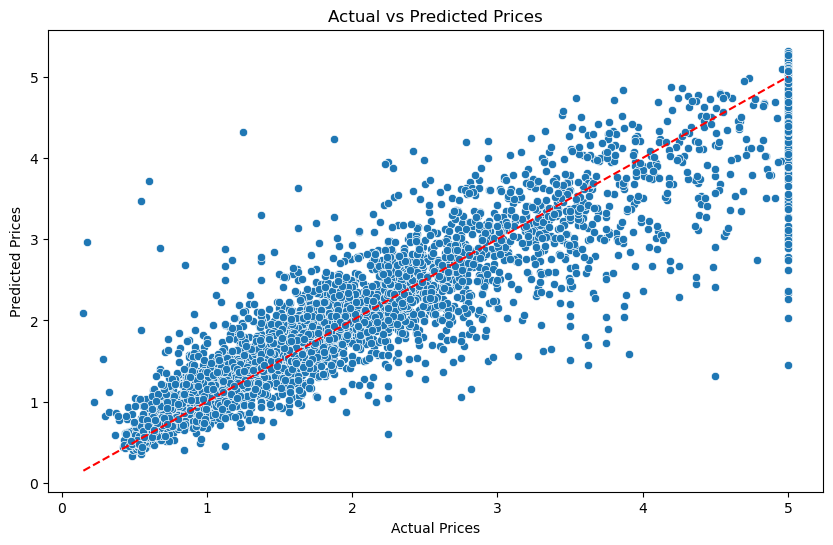

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing  # Ethical alternative
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from xgboost import XGBRegressor
from sklearn import metrics

# Load ethical dataset 
house_price_dataset = fetch_california_housing()

# Create DataFrame
house_price_dataframe = pd.DataFrame(house_price_dataset.data, 
                                    columns=house_price_dataset.feature_names)
house_price_dataframe['PRICE'] = house_price_dataset.target

# Exploratory Data Analysis (EDA)
print("Dataset Shape:", house_price_dataframe.shape)
print("\nMissing Values:\n", house_price_dataframe.isnull().sum())
print("\nStatistical Summary:\n", house_price_dataframe.describe())

# Correlation Analysis
plt.figure(figsize=(12,10))
correlation = house_price_dataframe.corr()
sns.heatmap(correlation, annot=True, fmt='.1f', cmap='coolwarm', 
            annot_kws={'size':8}, cbar=True, square=True)
plt.title('Feature Correlation Matrix')
plt.show()

# Prepare Data
X = house_price_dataframe.drop('PRICE', axis=1)
y = house_price_dataframe['PRICE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training with Hyperparameter Tuning
model = XGBRegressor(objective='reg:squarederror')
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Cross-Validation
cv_scores = cross_val_score(best_model, X, y, cv=5, 
                           scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f"\nCross-Validated RMSE: {cv_rmse.mean():.2f} ± {cv_rmse.std():.2f}")

# Predictions
train_pred = best_model.predict(X_train)
test_pred = best_model.predict(X_test)

# Performance Metrics
def print_metrics(actual, predicted, label):
    print(f"\n{label} Metrics:")
    print(f"R²: {metrics.r2_score(actual, predicted):.4f}")
    print(f"MAE: {metrics.mean_absolute_error(actual, predicted):.4f}")
    print(f"MSE: {metrics.mean_squared_error(actual, predicted):.4f}")
    print(f"RMSE: {np.sqrt(metrics.mean_squared_error(actual, predicted)):.4f}")
    print(f"MAPE: {np.mean(np.abs((actual - predicted)/actual))*100:.2f}%")
    print(f"Explained Variance: {metrics.explained_variance_score(actual, predicted):.4f}")

print_metrics(y_train, train_pred, "Training")
print_metrics(y_test, test_pred, "Test")

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance Ranking')
plt.show()

# Diagnostic Plots
residuals = y_test - test_pred

# Residual Plot
plt.figure(figsize=(10,6))
sns.scatterplot(x=test_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

# Error Distribution
plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True)
plt.xlabel('Prediction Errors')
plt.title('Error Distribution')
plt.show()

# Prediction vs Actual Plot
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=test_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()